In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt

In [8]:
#data stats boomb
competitions = pd.read_json(r'open-data-master/data/competitions.json')

In [18]:
concat_matchs = []
for i in competitions[competitions.competition_id == 11].season_id.to_list():
    matchs = pd.read_json(f'open-data-master/data/matches/11/{i}.json')
    concat_matchs.append(matchs)
    
matchs_messi = pd.concat(concat_matchs)

4
1
2
27
26
25
24
23
22
21
41
40
39
38
37


In [27]:
list_event = matchs_messi.match_id.to_list()

In [ ]:
event_messi_goal = []
for event in list_event:
    events = pd.read_json(f'open-data-master/data/events/{event}.json')
    events = events.dropna(subset=['player'])
    events = events.dropna(subset=['type'])
    events = events.reset_index(drop=True)
    for ids in range(len(events)):
        events.loc[ids, 'messi'] = events.loc[ids, 'player']['id']
        events.loc[ids, 'messishot'] = events.loc[ids, 'type']['name']
        
    events = events[(events['messi'] == 5503) & (events['messishot'] == 'Shot') ]

    event_messi_goal.append(events)

matchs_messi_event = pd.concat(event_messi_goal)

In [80]:
#save
matchs_messi_event.to_pickle('messishoot')

In [2]:
matchs_messi_event = pd.read_pickle(r'messishoot')

In [3]:
matchs_messi_event = matchs_messi_event.reset_index(drop = True)
for shot in range(len(matchs_messi_event)):
    matchs_messi_event.loc[shot, 'x'] = matchs_messi_event.loc[shot, 'shot']['end_location'][1]
    if len(matchs_messi_event.loc[shot, 'shot']['end_location']) == 3:
        matchs_messi_event.loc[shot,'y'] = matchs_messi_event.loc[shot, 'shot']['end_location'][2]
    matchs_messi_event.loc[shot,'typeofshot'] = matchs_messi_event.loc[shot, 'shot']['type']['name']
    matchs_messi_event.loc[shot,'result'] = matchs_messi_event.loc[shot, 'shot']['outcome']['name']
    

In [27]:
#scale data (statsbomb center field = 60,40) 
matchs_messi_event['xM'] = [(float(i) / 80 * 68) for i in matchs_messi_event.x]

In [115]:
xGoal = matchs_messi_event[(matchs_messi_event['result'] == "Goal") & (matchs_messi_event['typeofshot'] == 'Penalty')]['xM'].to_list()
zGoal = matchs_messi_event[(matchs_messi_event['result'] == "Goal") & (matchs_messi_event['typeofshot'] == 'Penalty')]['y'].to_list()

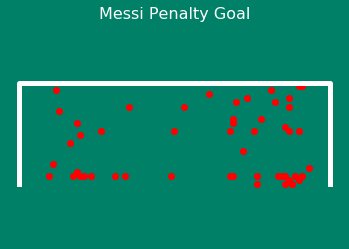

In [127]:
fig, ax = plt.subplots()
fig.set_facecolor('#008066ff')
ax.set_aspect('equal')
plt.scatter(xGoal, zGoal, c = 'red', zorder=1)
title = plt.title('Messi Penalty Goal')
title.set_fontsize(16)
title.set_color('white')
# fGoal = plt.hexbin(xGoal,zGoal,C=None,gridsize=3,bins=None, zorder=2, cmap= "cividis", edgecolors='#440154ff')
# countsGoal = fGoal.get_array()
# positionsGoal = fGoal.get_offsets() 

# for c, (x,y) in zip(countsGoal,positionsGoal):
#     if c != 0.0:

#         plt.text(x,y,"{:d}".format(int(c)), ha="center", va="center")
        
ly4 = [0,2.48,2.48,0]
lx4 = [30.30,30.30,37.90,37.90]
plt.plot(lx4,ly4,color='white',zorder=5, linewidth=5)
ax.axis('off')
plt.axis('equal')
ax.set_xlim(30, 38.2)
ax.set_ylim(0,2.5)
plt.show()

In [105]:
matchs_messi_event['typeofshot'].value_counts()

Open Play    1603
Free Kick     336
Penalty        64
Name: typeofshot, dtype: int64